In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
# !pip install explainerdashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

## Step 2: Load Data

In [103]:
# Load data
df = pd.read_csv('data_set/train.csv')
df_copy = df.copy()

## Step 3: Data Cleaning and Preprocessing for Categorical Data

In [104]:
# Include the object type columns except the 'Loan_ID' column
df_cat = df.select_dtypes(include=['object']).drop('Loan_ID', axis=1)

# Replace missing values with the most frequent value
for col in df_cat.columns:
    df_cat[col] = df_cat[col].fillna(df_cat[col].mode()[0])

df_cat.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y


In [105]:
# Separate the target variable before encoding
target = df_cat['Loan_Status']
df_cat = df_cat.drop(columns=['Loan_Status'])

## Step 4: Data Preprocessing for Numerical Data

In [106]:
numeric = df.select_dtypes(include=['int64', 'float64']).columns

for value in numeric:
    df[value] = df[value].fillna(df[value].median())

df_num = df[numeric]

## Step 5: Encode Categorical Variables

In [107]:
# Encode Categorical Variables using OneHotEncoder
df_cat['Dependents'] = df_cat['Dependents'].replace('3+', 3).astype(int)

one_hot_encoder = OneHotEncoder(sparse_output=False)
df_encoded = one_hot_encoder.fit_transform(df_cat)

## Step 6: Concatenate DataFrames

In [108]:
# Create a DataFrame from the encoded data
df_encoded = pd.DataFrame(df_encoded, columns=one_hot_encoder.get_feature_names_out())

# Concatenate DataFrames
df_concat = pd.concat([df_encoded, df_num.reset_index(drop=True)], axis=1)

In [109]:
# Add the target variable back to the DataFrame
df_concat['Loan_Status'] = target.reset_index(drop=True).map({'Y': 1, 'N': 0})

## Step 7: Data Information

In [110]:
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender_Female            614 non-null    float64
 1   Gender_Male              614 non-null    float64
 2   Married_No               614 non-null    float64
 3   Married_Yes              614 non-null    float64
 4   Dependents_0             614 non-null    float64
 5   Dependents_1             614 non-null    float64
 6   Dependents_2             614 non-null    float64
 7   Dependents_3             614 non-null    float64
 8   Education_Graduate       614 non-null    float64
 9   Education_Not Graduate   614 non-null    float64
 10  Self_Employed_No         614 non-null    float64
 11  Self_Employed_Yes        614 non-null    float64
 12  Property_Area_Rural      614 non-null    float64
 13  Property_Area_Semiurban  614 non-null    float64
 14  Property_Area_Urban      6

## Step 8: Split Data into Training and Test Sets

In [111]:
# Split the data
X = df_concat.drop(columns=['Loan_Status', 'Gender_Female', 'Married_No', 'Education_Not Graduate'])
y = df_concat['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=21)

## Step 9: Normalize Data

In [112]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert X_train and X_test back to DataFrames for the ExplainerDashboard
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)


## Step 10: Train Logistic Regression Model

In [113]:
# Train Logistic Regression Model
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Step 11: Model Prediction

In [114]:
predict_lr = model_lr.predict(X_test)
predict_lr

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1], dtype=int64)

## Step 12: Evaluate Model Performance

In [115]:
# Evaluate model performance
train_score_lr = model_lr.score(X_train, y_train)
test_score_lr = model_lr.score(X_test, y_test)
train_score_lr, test_score_lr

(0.8085539714867617, 0.8048780487804879)

## Step 13: Correlation Matrix

<Axes: >

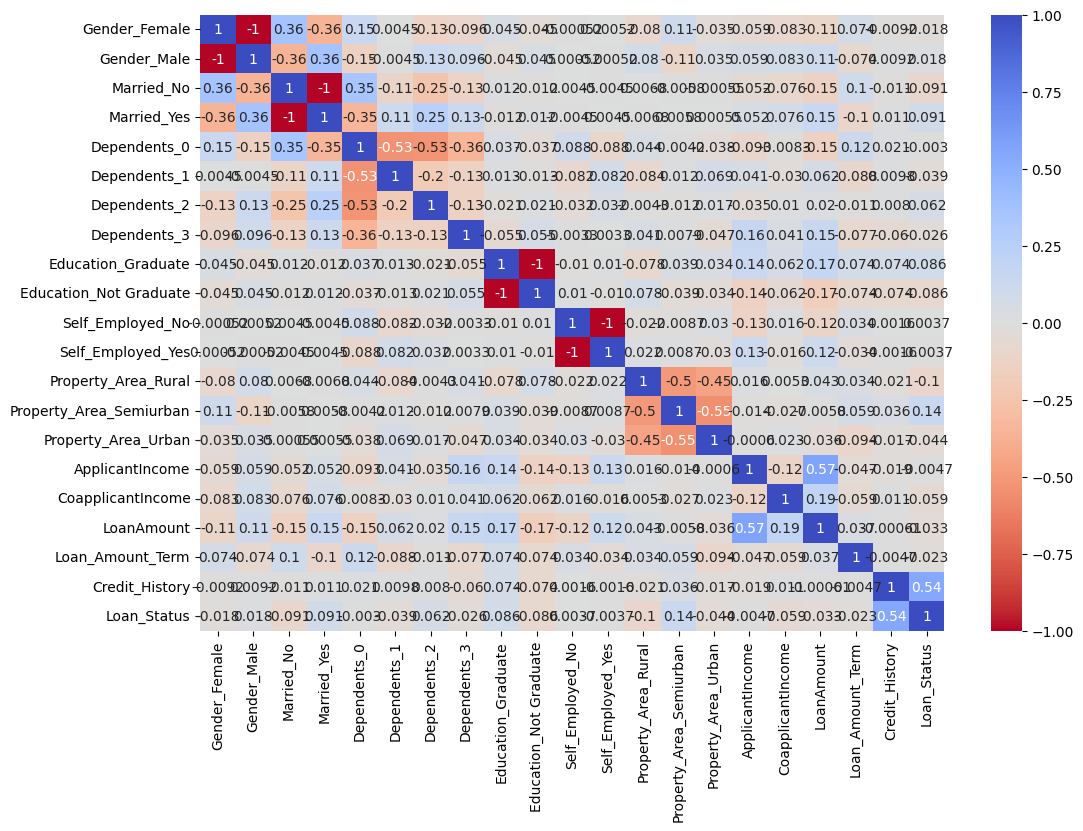

In [116]:
# Calculate correlation matrix
matrix = df_concat.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm_r')

## Step 14: Train Random Forest Model with Hyperparameter Tuning

In [117]:
model_rf = RandomForestClassifier(random_state=21)

# Define the parameters to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configure Grid Search
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Meilleurs paramètres : {best_params}")


best_model = grid_search.best_estimator_
train_score_rf = best_model.score(X_train, y_train)
test_score_rf = best_model.score(X_test, y_test)
print(f"Score d'entraînement : {train_score_rf}")
print(f"Score de test : {test_score_rf}")

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Meilleurs paramètres : {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Score d'entraînement : 0.8268839103869654
Score de test : 0.8211382113821138


## Step 15: Cross-Validation

In [118]:
# Cross-validation with RandomForest
cv_scores_rf = cross_val_score(best_model, X_train, y_train, cv=5)
cv_score_mean_rf = cv_scores_rf.mean()

print(f"Score d'entraînement : {train_score_rf}")
print(f"Score de test : {test_score_rf}")
print(f"Score de validation croisée (moyenne) : {cv_score_mean_rf}")

Score d'entraînement : 0.8268839103869654
Score de test : 0.8211382113821138
Score de validation croisée (moyenne) : 0.8064522778808494


# Step 16: Create ExplainerDashboard for Logistic Regression

In [119]:
# explainer_lr = ClassifierExplainer(model_lr, X_test, y_test)
# dashboard_lr = ExplainerDashboard(explainer_lr, title="Logistic Regression Explainer Dashboard")
# dashboard_lr.run(port=8050, host='localhost')

# Step 17: Create ExplainerDashboard for Random Forest

In [120]:
# explainer_rf = ClassifierExplainer(best_model, X_test, y_test)
# dashboard_rf = ExplainerDashboard(explainer_rf, title="Random Forest Explainer Dashboard")
# dashboard_rf.run(port=8050, host='localhost')